# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# Loading the dataset

In [46]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations for training and testing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


# Finetuning AlexNet and VGG16

In [47]:
# Load pre-trained models
alexnet_finetune = models.alexnet(weights='IMAGENET1K_V1')
vgg16_finetune = models.vgg16(weights='IMAGENET1K_V1')

# Modify the final layer to match CIFAR10 classes (10 classes)
alexnet_finetune.classifier[6] = nn.Linear(alexnet_finetune.classifier[6].in_features, 10)
vgg16_finetune.classifier[6] = nn.Linear(vgg16_finetune.classifier[6].in_features, 10)

alexnet_finetune = alexnet_finetune.to(device)
vgg16_finetune = vgg16_finetune.to(device)

# ConvNet as fixed feature extractor

In [48]:
# Load pre-trained models
alexnet_feature_extractor = models.alexnet(weights='IMAGENET1K_V1')
vgg16_feature_extractor = models.vgg16(weights='IMAGENET1K_V1')

# Freeze all layers except the final layer
for param in alexnet_feature_extractor.parameters():
    param.requires_grad = False
for param in vgg16_feature_extractor.parameters():
    param.requires_grad = False

# Modify the final layer to match CIFAR10 classes (10 classes) and enable its gradients
alexnet_feature_extractor.classifier[6] = nn.Linear(alexnet_feature_extractor.classifier[6].in_features, 10)
vgg16_feature_extractor.classifier[6] = nn.Linear(vgg16_feature_extractor.classifier[6].in_features, 10)

alexnet_feature_extractor.classifier[6].weight.requires_grad = True
alexnet_feature_extractor.classifier[6].bias.requires_grad = True

vgg16_feature_extractor.classifier[6].weight.weightrequires_grad = True
vgg16_feature_extractor.classifier[6].bias.requires_grad = True

alexnet_feature_extractor = alexnet_feature_extractor.to(device)
vgg16_feature_extractor = vgg16_feature_extractor.to(device)

# Training and testing functions

In [49]:
def train_model(model, criterion, optimizer, dataloader, epochs=3):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 200 == 199:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Finetuning procedure

In [50]:
# Fine-tuning: AlexNet and VGG16
criterion = nn.CrossEntropyLoss()

optimizer_alexnet_finetune = torch.optim.SGD(alexnet_finetune.parameters(), lr=0.001, momentum=0.9)
optimizer_vgg16_finetune = torch.optim.SGD(vgg16_finetune.parameters(), lr=0.001, momentum=0.9)

# Train and evaluate AlexNet Fine-tuning
print("Training AlexNet Fine-tuning")
train_model(alexnet_finetune, criterion, optimizer_alexnet_finetune, trainloader)
alexnet_finetune_accuracy = evaluate_model(alexnet_finetune, testloader)

# Train and evaluate VGG16 Fine-tuning
print("Training VGG16 Fine-tuning")
train_model(vgg16_finetune, criterion, optimizer_vgg16_finetune, trainloader)
vgg16_finetune_accuracy = evaluate_model(vgg16_finetune, testloader)

print(f'AlexNet Fine-tuning Accuracy: {alexnet_finetune_accuracy}%')
print(f'VGG16 Fine-tuning Accuracy: {vgg16_finetune_accuracy}%')

Training AlexNet Fine-tuning
[1,   200] loss: 1.014
[1,   400] loss: 0.718
[1,   600] loss: 0.621
[1,   800] loss: 0.588
[1,  1000] loss: 0.536
[1,  1200] loss: 0.536
[1,  1400] loss: 0.504
[2,   200] loss: 0.418
[2,   400] loss: 0.418
[2,   600] loss: 0.412
[2,   800] loss: 0.383
[2,  1000] loss: 0.415
[2,  1200] loss: 0.380
[2,  1400] loss: 0.400
[3,   200] loss: 0.329
[3,   400] loss: 0.311
[3,   600] loss: 0.316
[3,   800] loss: 0.313
[3,  1000] loss: 0.315
[3,  1200] loss: 0.322
[3,  1400] loss: 0.305
Training VGG16 Fine-tuning
[1,   200] loss: 0.892
[1,   400] loss: 0.532
[1,   600] loss: 0.455
[1,   800] loss: 0.415
[1,  1000] loss: 0.401
[1,  1200] loss: 0.392
[1,  1400] loss: 0.349
[2,   200] loss: 0.253
[2,   400] loss: 0.251
[2,   600] loss: 0.243
[2,   800] loss: 0.236
[2,  1000] loss: 0.250
[2,  1200] loss: 0.230
[2,  1400] loss: 0.248
[3,   200] loss: 0.152
[3,   400] loss: 0.152
[3,   600] loss: 0.155
[3,   800] loss: 0.158
[3,  1000] loss: 0.165
[3,  1200] loss: 0.153
[

# ConvNet as Fixed Feature Extractor procedure

In [51]:
# ConvNet as Fixed Feature Extractor: AlexNet and VGG16
optimizer_alexnet_feature_extractor = torch.optim.SGD(alexnet_feature_extractor.classifier[6].parameters(), lr=0.001, momentum=0.9)
optimizer_vgg16_feature_extractor = torch.optim.SGD(vgg16_feature_extractor.classifier[6].parameters(), lr=0.001, momentum=0.9)

# Train and evaluate AlexNet Feature Extractor
print("Training AlexNet as Fixed Feature Extractor")
train_model(alexnet_feature_extractor, criterion, optimizer_alexnet_feature_extractor, trainloader)
alexnet_feature_extractor_accuracy = evaluate_model(alexnet_feature_extractor, testloader)

# Train and evaluate VGG16 Feature Extractor
print("Training VGG16 as Fixed Feature Extractor")
train_model(vgg16_feature_extractor, criterion, optimizer_vgg16_feature_extractor, trainloader)
vgg16_feature_extractor_accuracy = evaluate_model(vgg16_feature_extractor, testloader)

print(f'AlexNet Fixed Feature Extractor Accuracy: {alexnet_feature_extractor_accuracy}%')
print(f'VGG16 Fixed Feature Extractor Accuracy: {vgg16_feature_extractor_accuracy}%')

Training AlexNet as Fixed Feature Extractor
[1,   200] loss: 1.058
[1,   400] loss: 0.819
[1,   600] loss: 0.768
[1,   800] loss: 0.775
[1,  1000] loss: 0.730
[1,  1200] loss: 0.714
[1,  1400] loss: 0.738
[2,   200] loss: 0.695
[2,   400] loss: 0.669
[2,   600] loss: 0.684
[2,   800] loss: 0.698
[2,  1000] loss: 0.679
[2,  1200] loss: 0.707
[2,  1400] loss: 0.656
[3,   200] loss: 0.656
[3,   400] loss: 0.665
[3,   600] loss: 0.666
[3,   800] loss: 0.662
[3,  1000] loss: 0.655
[3,  1200] loss: 0.660
[3,  1400] loss: 0.643
Training VGG16 as Fixed Feature Extractor
[1,   200] loss: 1.061
[1,   400] loss: 0.759
[1,   600] loss: 0.723
[1,   800] loss: 0.689
[1,  1000] loss: 0.674
[1,  1200] loss: 0.667
[1,  1400] loss: 0.656
[2,   200] loss: 0.628
[2,   400] loss: 0.626
[2,   600] loss: 0.622
[2,   800] loss: 0.660
[2,  1000] loss: 0.636
[2,  1200] loss: 0.625
[2,  1400] loss: 0.638
[3,   200] loss: 0.589
[3,   400] loss: 0.657
[3,   600] loss: 0.629
[3,   800] loss: 0.592
[3,  1000] loss: 

# Plotting the results

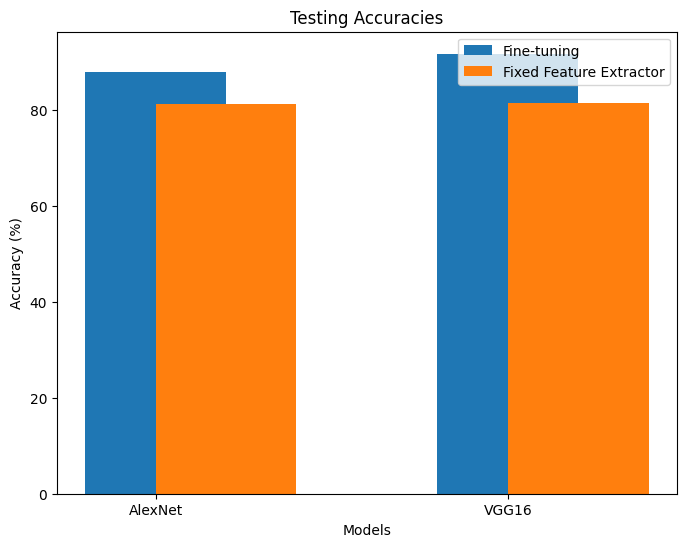

In [53]:
models = ['AlexNet', 'VGG16']
accuracies_finetune = [alexnet_finetune_accuracy, vgg16_finetune_accuracy]
accuracies_feature_extractor = [alexnet_feature_extractor_accuracy, vgg16_feature_extractor_accuracy]

x = range(len(models))

plt.figure(figsize=(8, 6))
plt.bar(x, accuracies_finetune, width=0.4, label='Fine-tuning', align='center')
plt.bar(x, accuracies_feature_extractor, width=0.4, label='Fixed Feature Extractor', align='edge')

plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracies')
plt.xticks(x, models)
plt.legend()

plt.show()

# Result analysis

## Finetuning

In the context of the CIFAR10 dataset, VGG16 has outperformed AlexNet by achieving a test accuracy of 91.64%, whereas AlexNet reached 87.83%. The superior performance of VGG16 can be attributed to its deeper architecture, which allows it to capture more complex and intricate features within the data. Throughout the training process, both models effectively minimized training losses, but VGG16 consistently maintained lower loss values.

However, the increased depth and complexity of VGG16 come with significant trade-offs. The model demands more computational power, resulting in longer training times and higher memory usage. Despite these challenges, VGG16's ability to deliver higher accuracy and better generalization makes it a powerful choice for tasks requiring high performance.

On the other hand, AlexNet remains a practical alternative for environments with restricted computational resources. Its simpler architecture leads to lower computational requirements, making it a feasible option when resources are limited. Thus, while VGG16 is preferable for achieving maximum accuracy, AlexNet offers a balanced approach for situations where computational efficiency is crucial.

## ConvNet as Fixed Feature Extractor

AlexNet and VGG16 both achieved good results on the CIFAR-10 dataset, with accuracies of 81.22% and 81.42%, respectively. Despite the considerable differences in their architectures and depths, these models performed similarly well when pre-trained features were utilized and only the final fully connected layer was fine-tuned.

This outcome highlights an intriguing aspect of transfer learning. It suggests that for the CIFAR-10 dataset, the depth and complexity of the model architecture might not play a significant role in performance. The pre-trained features from both AlexNet and VGG16 appear to be robust enough to generalize effectively to this task, making the architectural nuances less critical.

Furthermore, this observation underscores the efficiency of transfer learning. It reduces the need for extensive training on large datasets, especially for tasks where fine-tuning pre-trained models is more crucial than constructing complex models from scratch. This efficiency demonstrates how powerful transfer learning can be in leveraging pre-trained features to achieve high performance with relatively minimal additional training.